In [1]:
import numpy as np
import tensorflow as tf
import os
import tensorflow_io as tfio
import matplotlib.pyplot as plt

print(os.getcwd())
print(os.listdir())
CAPUCHIN_FILE = 'Kapucalls/Parsed_Capuchinbird_Clips/XC3776-0.wav'
NOT_CAPUCHIN_FILE = 'Kapucalls/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav'

c:\Ebooks\code
['.vscode', 'AIRTG', 'Baseline.py', 'books', 'CP', 'data', 'Kapu.ipynb', 'Kapucalls', 'Lang', 'Machine Learning', 'Projects', 'ProR', 'RainSense', 'SortVerse', 'SST-2.zip', 'WW.py']


In [2]:
from scipy.signal import resample_poly

def load_wav_16k_mono(filename):
    # Load encoded WAV file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = int(sample_rate.numpy())
    # Convert to NumPy array for resampling
    wav_np = wav.numpy()
    # Resample to 16kHz using SciPy
    resampled_wav = resample_poly(wav_np, up=16000, down=sample_rate)
    # Convert back to TensorFlow tensor
    resampled_wav = tf.convert_to_tensor(resampled_wav, dtype=tf.float32)
    return resampled_wav


In [3]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

In [4]:
print(wave.shape)

(48000,)


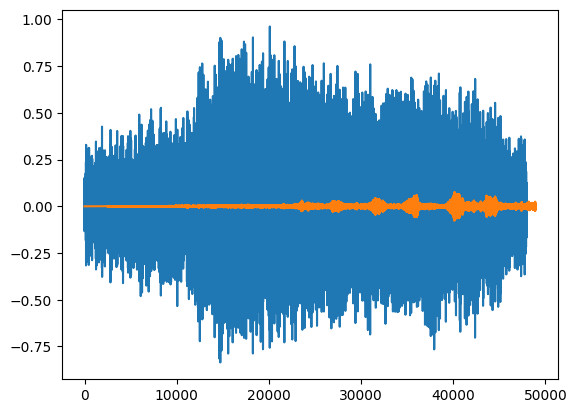

In [5]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [6]:
POS = os.path.join('Kapucalls', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('Kapucalls', 'Parsed_Not_Capuchinbird_Clips')

In [7]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [8]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [9]:
lengths = []
for file in os.listdir(os.path.join('Kapucalls', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('Kapucalls', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [10]:
tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [11]:
def preprocess(file_path, label):
    def _preprocess(file_path, label):
        file_path_str = file_path.numpy().decode("utf-8")
        if not tf.io.gfile.exists(file_path_str):
            raise FileNotFoundError("File does not exist: " + file_path_str)
        wav = load_wav_16k_mono(file_path_str)
        wav = wav[:48000]
        zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
        wav = tf.concat([zero_padding, wav], 0)
        spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
        spectrogram = tf.abs(spectrogram)
        spectrogram = tf.expand_dims(spectrogram, axis=2)
        spectrogram = tf.image.resize(spectrogram, [32, 32])
        return spectrogram, label
    
    return tf.py_function(_preprocess, [file_path, label], [tf.float32, label.dtype])



In [12]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [67]:
spectogram, label = preprocess(filepath, label)

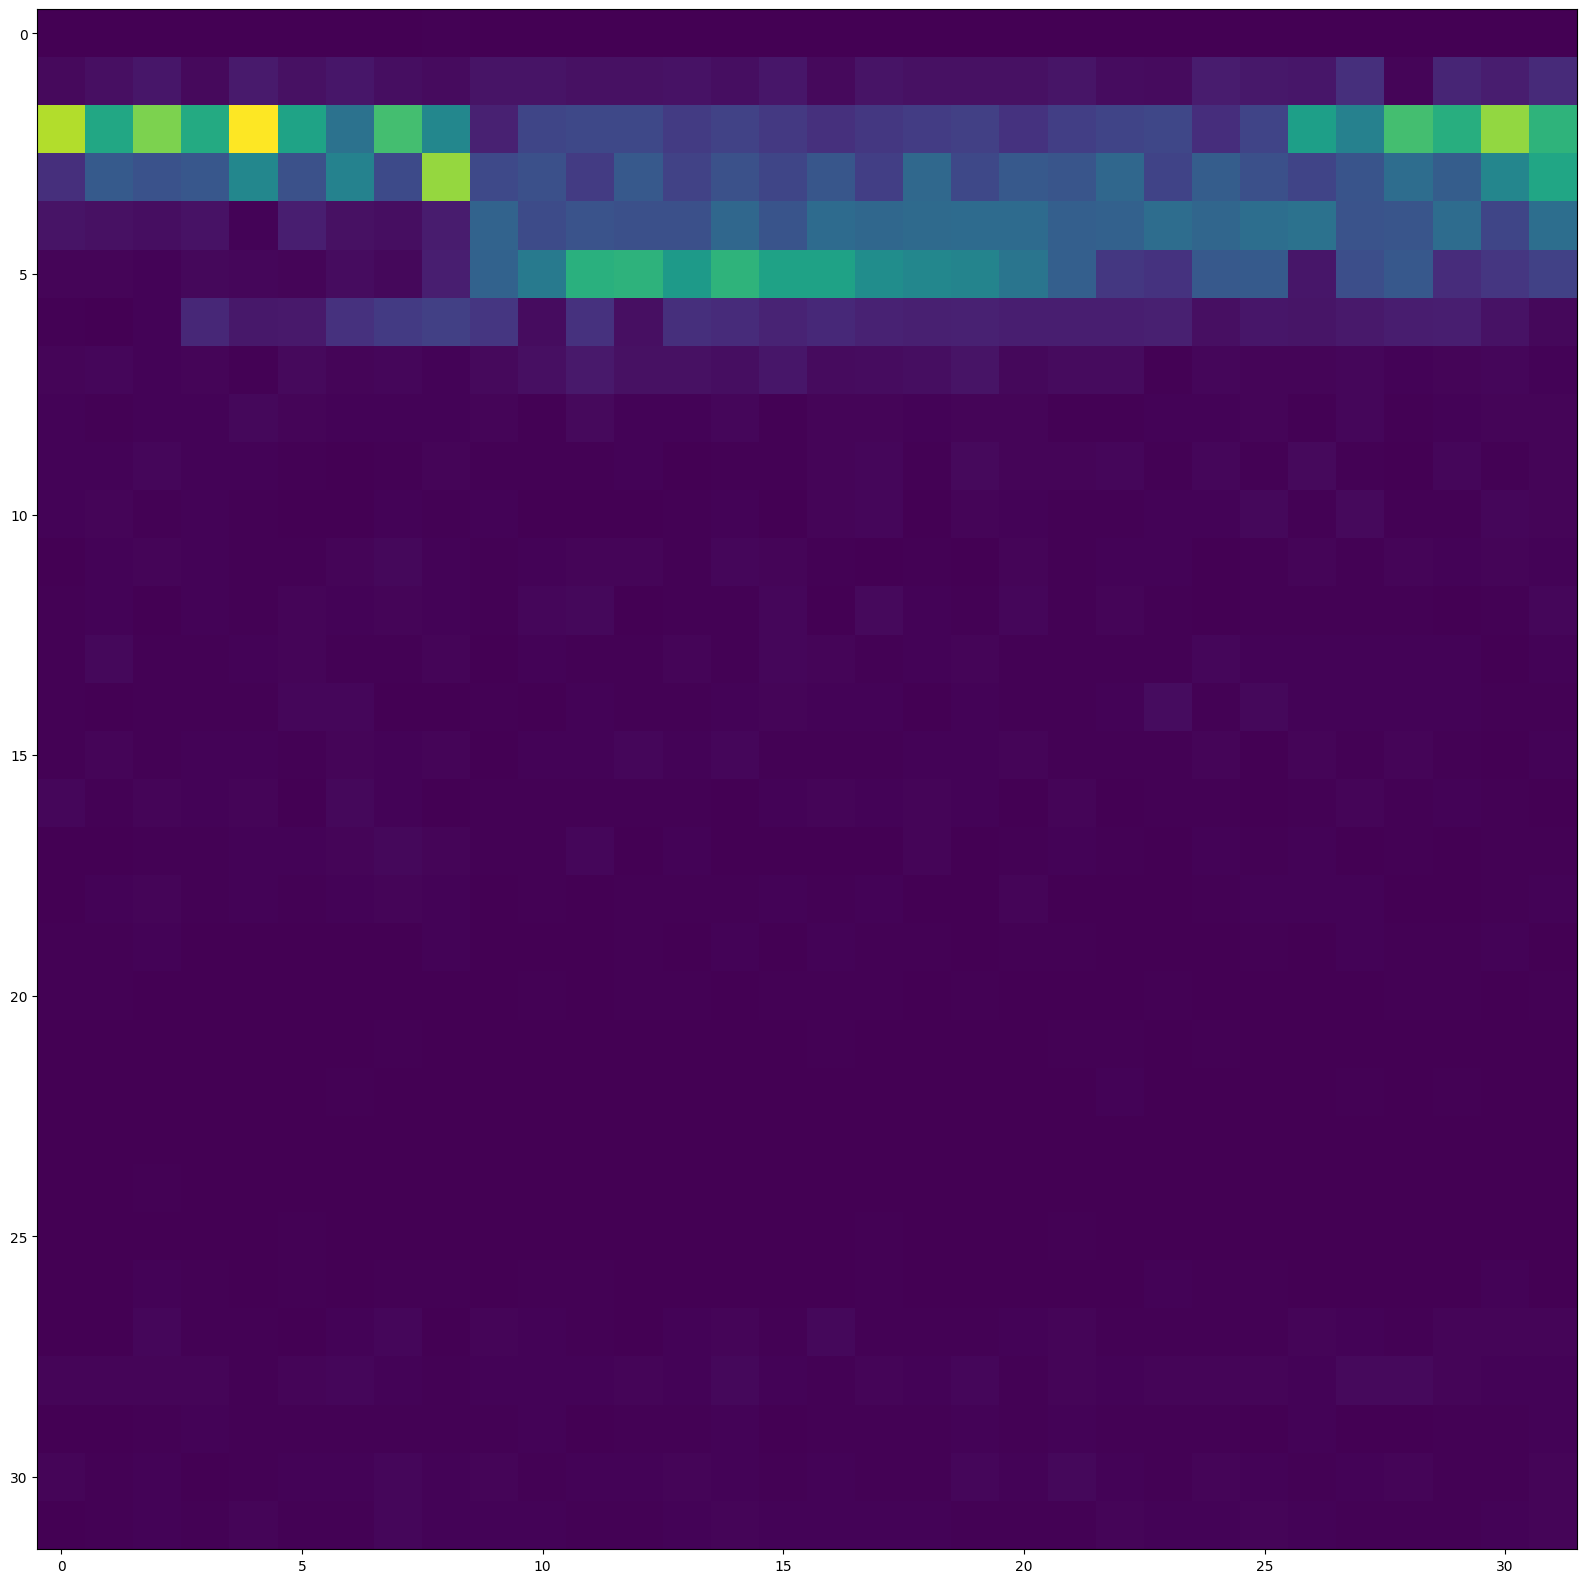

In [68]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()

In [15]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16, drop_remainder=True)
data = data.prefetch(8)

In [16]:
train = data.take(36)
test = data.skip(36).take(15)

In [17]:
samples, labels = train.as_numpy_iterator().next()

In [18]:
samples.shape

(16, 32, 32, 1)

In [19]:
#ACTUAL MODEL

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D

In [26]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    Conv2D(16, (3, 3), activation='relu'),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [27]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(), 'accuracy', tf.keras.metrics.Precision()])

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 16)        160       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 global_average_pooling2d (G  (None, 16)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 128)               2176      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,785
Trainable params: 4,785
Non-trainable params: 0
____________________________________________________

In [29]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 3s 30ms/step - loss: 0.6493 - recall_1: 0.0523 - precision_1: 0.4000 - val_loss: 0.5693 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 2/4
36/36 [==============================] - 0s 13ms/step - loss: 0.5035 - recall_1: 0.1801 - precision_1: 0.9667 - val_loss: 0.4042 - val_recall_1: 0.3966 - val_precision_1: 0.9583
Epoch 3/4
36/36 [==============================] - 0s 13ms/step - loss: 0.3644 - recall_1: 0.5097 - precision_1: 0.9294 - val_loss: 0.3653 - val_recall_1: 0.5797 - val_precision_1: 0.9091
Epoch 4/4
36/36 [==============================] - 0s 14ms/step - loss: 0.3373 - recall_1: 0.5325 - precision_1: 0.9318 - val_loss: 0.2905 - val_recall_1: 0.6724 - val_precision_1: 0.8667


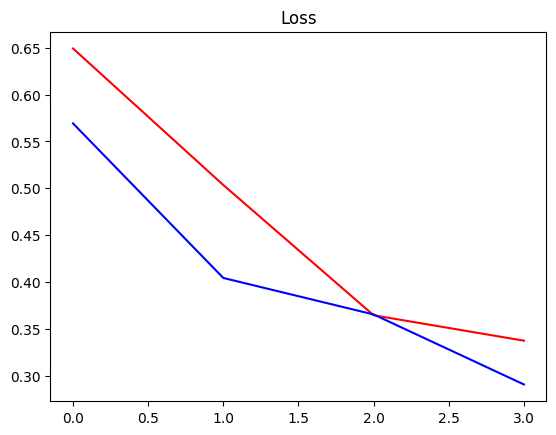

In [30]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

KeyError: 'precision'

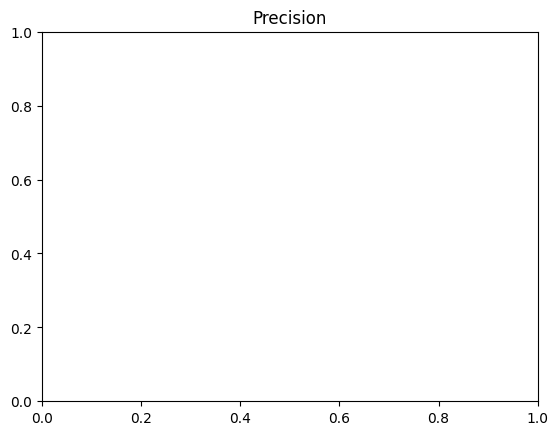

In [31]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

KeyError: 'recall'

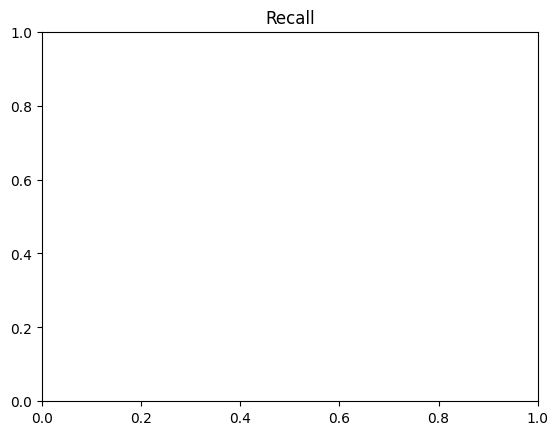

In [32]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [33]:
X_test, y_test = test.as_numpy_iterator().next()

In [34]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 106ms/step


In [35]:

yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [48]:
import librosa
def load_mp3_16k_mono(filename):
    """ Load an MP3 file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    audio, sample_rate = librosa.load(filename, sr=16000, mono=True)
    audio = tf.convert_to_tensor(audio, dtype=tf.float32)
    return audio


In [49]:
mp3 = os.path.join('Kapucalls', 'Forest Recordings', 'recording_00.mp3')

In [50]:
wav = load_mp3_16k_mono(mp3)

In [51]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [52]:
samples, index = audio_slices.as_numpy_iterator().next()

In [53]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [54]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [55]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 [==============================] - 12s 2s/step


In [56]:
from itertools import groupby

In [57]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()


In [58]:
calls

0

In [61]:
results = {}
for file in os.listdir(os.path.join('Kapucalls', 'Forest Recordings')):
    FILEPATH = os.path.join('Kapucalls','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

1/1 [==============================] - 3s 3s/step


In [62]:
results

{'recording_00.mp3': array([[0.13123924],
        [0.14364944],
        [0.14851832],
        [0.3927931 ],
        [0.9757708 ],
        [0.28774688],
        [0.15387285],
        [0.1447787 ],
        [0.15164621],
        [0.13598797],
        [0.140653  ],
        [0.14477907],
        [0.1435857 ],
        [0.5815642 ],
        [0.9731334 ],
        [0.153331  ],
        [0.22385734],
        [0.14277498],
        [0.13610697],
        [0.14258066],
        [0.14216015],
        [0.1438077 ],
        [0.13786888],
        [0.31127283],
        [0.9762856 ],
        [0.32322535],
        [0.16591832],
        [0.13871677],
        [0.1577319 ],
        [0.14406191],
        [0.14022619],
        [0.13976212],
        [0.1948134 ],
        [0.19303052],
        [0.13380373],
        [0.24830511],
        [0.9736874 ],
        [0.40175906],
        [0.14570622],
        [0.13648015],
        [0.14439467],
        [0.15231149],
        [0.14571442],
        [0.1564154 ],
        [0.1

In [63]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

In [64]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 0,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 0,
 'recording_05.mp3': 0,
 'recording_06.mp3': 1,
 'recording_07.mp3': 0,
 'recording_08.mp3': 0,
 'recording_09.mp3': 0,
 'recording_10.mp3': 1,
 'recording_11.mp3': 1,
 'recording_12.mp3': 4,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 1,
 'recording_16.mp3': 0,
 'recording_17.mp3': 0,
 'recording_18.mp3': 0,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 0,
 'recording_22.mp3': 0,
 'recording_23.mp3': 0,
 'recording_24.mp3': 0,
 'recording_25.mp3': 0,
 'recording_26.mp3': 0,
 'recording_27.mp3': 0,
 'recording_28.mp3': 3,
 'recording_29.mp3': 0,
 'recording_30.mp3': 2,
 'recording_31.mp3': 0,
 'recording_32.mp3': 0,
 'recording_33.mp3': 0,
 'recording_34.mp3': 1,
 'recording_35.mp3': 0,
 'recording_36.mp3': 3,
 'recording_37.mp3': 1,
 'recording_38.mp3': 0,
 'recording_39.mp3': 2,
 'recording_40.mp3': 0,
 'recording_41.m

In [65]:
import csv 
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])